## Buliding a Basic chatbot

In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages


In [2]:
class State(TypedDict):
    messages:Annotated[list,add_messages]
    
    
graph_builder=StateGraph(State)

In [3]:
graph_builder

In [4]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [5]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct")

In [6]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002C6C53E8250>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002C6C55383D0>, model_name='meta-llama/llama-4-scout-17b-16e-instruct', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [7]:
# llm=init_chat_model("groq:meta-llama/llama-4-scout-17b-16e-instruct")
# llm

In [8]:
def chatbot(state:State):
    return {"messages":[llm.invoke(state['messages'])]}

In [9]:
## Adding Node
graph_builder=StateGraph(State)
graph_builder.add_node('llmchatbot',chatbot)

## Adding Edge
graph_builder.add_edge(START,'llmchatbot')
graph_builder.add_edge('llmchatbot',END)

graph=graph_builder.compile()

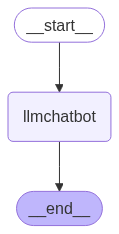

In [10]:
from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [11]:
response=graph.invoke({'messages':'Hi'})

In [12]:
response["messages"][-1].content

"Hello! It's nice to meet you. Is there something I can help you with, or would you like to chat?"

In [13]:
for event in graph.stream({"messages":"Hi, How are you?"}):
    for value in event.values():
        print(value['messages'][-1].content)

I'm just a language model, I don't have feelings like humans do, but I'm functioning properly and ready to help you with any questions or tasks you have! How can I assist you today?


## Chatbot with tools

In [14]:
from langchain_tavily import TavilySearch

tool= TavilySearch(max_results=2)
tool.invoke("What is langgraph")

{'query': 'What is langgraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
   'title': 'LangGraph Tutorial: What Is LangGraph and How to Use It?',
   'content': 'LangGraph is a library within the LangChain ecosystem that provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured and efficient manner. By managing the flow of data and the sequence of operations, LangGraph allows developers to focus on the high-level logic of their applications rather than the intricacies of agent coordination. Whether you need a chatbot that can handle various types of user requests or a multi-agent system that performs complex tasks, LangGraph provides the tools to build exactly what you need. LangGraph significantly simplifies the development of complex LLM applications by providing a structured framework for managing state and coordinating agent interaction

In [30]:
def multiply(a:int,b:int)->int:
    """
Multiply two integers and return the result.

Args:
    a (int): The first integer or string.
    b (int): The second integer or string.

Returns:
    int: The product of `a` and `b`.
"""
    if isinstance(a,str):
        a=int(a)

    if isinstance(b,str):
        b=int(b)

    c = a * b
    
    return c

In [31]:
tools=[tool,multiply]

In [32]:
llm_with_tools=llm.bind_tools(tools)

In [33]:
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002C6C53E8250>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002C6C55383D0>, model_name='meta-llama/llama-4-scout-17b-16e-instruct', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': 

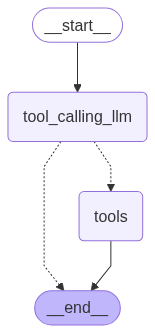

In [34]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node Defination
def tool_calling_llm(state:State):
    return {'messages':[llm_with_tools.invoke(state["messages"])]}

## Graph 
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node('tools',ToolNode(tools))

## Edges
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tool condition routes to tools.
    # If the latest message (result) from assistant is not a tool call -> tool condition routes it to END.
    tools_condition
)

builder.add_edge("tools",END)

## compile the graph

graph=builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [35]:
response=graph.invoke({"messages":"What is the recent AI news"})

In [36]:
response["messages"][-1].content

'{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.newscientist.com/article/2489248-deepmind-and-openai-claim-gold-in-international-mathematical-olympiad/", "title": "DeepMind and OpenAI claim gold in International Mathematical Olympiad - New Scientist", "score": 0.6364215, "published_date": "Tue, 22 Jul 2025 16:05:51 GMT", "content": "On 19 July, OpenAI announced that a new AI it had developed had achieved a gold medal score marked by three former IMO medallists separate from the official competition. The AI answered five out of six questions correctly in the same 4.5-hour time limit as the contestants, OpenAI said. [...] Two days later, Google DeepMind also announced that its AI system, called Gemini Deep Think, had achieved gold with the same score and time limits. Dolinar confirmed that this result was given by the IMO’s official markers. [...] After last year’s competition held in Bath, UK, Google DeepMindannoun

In [37]:
for message in response["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is the recent AI news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (2c3cy6t7y)
 Call ID: 2c3cy6t7y
  Args:
    query: recent AI news
    search_depth: advanced
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.newscientist.com/article/2489248-deepmind-and-openai-claim-gold-in-international-mathematical-olympiad/", "title": "DeepMind and OpenAI claim gold in International Mathematical Olympiad - New Scientist", "score": 0.6364215, "published_date": "Tue, 22 Jul 2025 16:05:51 GMT", "content": "On 19 July, OpenAI announced that a new AI it had developed had achieved a gold medal score marked by three former IMO medallists separate from the official competi

In [38]:
response=graph.invoke({"messages":"What is 2 multiplied by 3?"})
for message in response["messages"]:
    message.pretty_print()  

================================ Human Message =================================

What is 2 multiplied by 3?
================================== Ai Message ==================================
Tool Calls:
  multiply (d1y4efp56)
 Call ID: d1y4efp56
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


In [39]:
response=graph.invoke({"messages":"What is the recent AI news And then 2 multiplied by 3?"})
for message in response["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is the recent AI news And then 2 multiplied by 3?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (7bxd750p6)
 Call ID: 7bxd750p6
  Args:
    query: recent AI news
    search_depth: advanced
    topic: news
  multiply (r8hh208wh)
 Call ID: r8hh208wh
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.newscientist.com/article/2489248-deepmind-and-openai-claim-gold-in-international-mathematical-olympiad/", "title": "DeepMind and OpenAI claim gold in International Mathematical Olympiad - New Scientist", "score": 0.6364215, "published_date": "Tue, 22 Jul 2025 16:05:51 GMT", "content": "On 19 July, OpenAI announced that a new AI it had developed had ach

## ReAct Agent Architecture

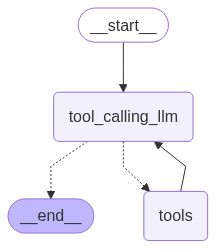

In [40]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node Defination
def tool_calling_llm(state:State):
    return {'messages':[llm_with_tools.invoke(state["messages"])]}

## Graph 
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node('tools',ToolNode(tools))

## Edges
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tool condition routes to tools.
    # If the latest message (result) from assistant is not a tool call -> tool condition routes it to END.
    tools_condition
)

builder.add_edge("tools","tool_calling_llm")

## compile the graph

graph=builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [41]:
response=graph.invoke({"messages":"What is the recent AI news also arrange it in points, And then 2 multiplied by 3?"})
for message in response["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is the recent AI news also arrange it in points, And then 2 multiplied by 3?
================================== Ai Message ==================================

Recent AI news includes:

* Google's DeepMind has developed an AI model that can predict the structure of proteins, which could lead to breakthroughs in fields such as medicine and biotechnology.
* Researchers at MIT have developed an AI system that can learn to play video games at a superhuman level, which could have implications for the development of more sophisticated AI systems.
* A new AI system developed by researchers at the University of California, Berkeley, can learn to recognize and classify images with a high degree of accuracy, which could have applications in fields such as self-driving cars and medical imaging.
* The European Union has announced plans to establish a new regulatory framework for AI, which could have significant i

## Adding Memory To Agentic AI Graph

In [43]:
response=graph.invoke({"messages":"Hello my name is Piyush."})
for message in response["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hello my name is Piyush.
================================== Ai Message ==================================

Hello Piyush! It's nice to meet you. Is there something I can help you with or would you like to chat?


In [44]:
response=graph.invoke({"messages":"What is my name?"})
for message in response["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

I don't have access to personal information about you, including your name. Is there something else I can assist you with?


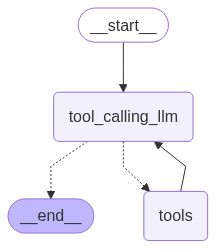

In [46]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver   # This checkpoint saver stores checkpoints in memory using a defaultdict.

memory = MemorySaver()

## Node Defination
def tool_calling_llm(state:State):
    return {'messages':[llm_with_tools.invoke(state["messages"])]}

## Graph 
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node('tools',ToolNode(tools))

## Edges
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tool condition routes to tools.
    # If the latest message (result) from assistant is not a tool call -> tool condition routes it to END.
    tools_condition
)

builder.add_edge("tools","tool_calling_llm")

## compile the graph

graph=builder.compile(checkpointer = memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
config={"configurable":{"thread_id":"1"}}   # It shoould be a unique id binded to a session or the conversation as a reference for the conversation and it should be unique.

response=graph.invoke({"messages":"Hi my name is Piyush"},config=config)
for message in response["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hi my name is Piyush
================================== Ai Message ==================================

Hello Piyush! It's nice to meet you. Is there something I can help you with or would you like to chat?


In [49]:
response=graph.invoke({"messages":"Hey, What is my name?"},config=config)
for message in response["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hi my name is Piyush
================================== Ai Message ==================================

Hello Piyush! It's nice to meet you. Is there something I can help you with or would you like to chat?
================================ Human Message =================================

Hey, What is my name?
================================== Ai Message ==================================

Your name is Piyush.


In [ ]:
response=graph.invoke({"messages":"Hey, Do you remember me?"},config=config)
for message in response["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hi my name is Piyush
================================== Ai Message ==================================

Hello Piyush! It's nice to meet you. Is there something I can help you with or would you like to chat?
================================ Human Message =================================

Hey, What is my name?
================================== Ai Message ==================================

Your name is Piyush.
================================ Human Message =================================

Hey, Do you remember me?
================================== Ai Message ==================================

Yes, I remember you. You mentioned earlier that your name is Piyush.


## Streaming The LangGraph

In [51]:
from langgraph.checkpoint.memory import MemorySaver   # This checkpoint saver stores checkpoints in memory using a defaultdict.

memory = MemorySaver()

In [52]:
def Superbot(state:State):
    return ({"messages":[llm.invoke(state['messages'])]})

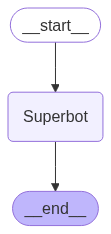

In [54]:
graph=StateGraph(State)

## Node
graph.add_node("Superbot",Superbot)

## Edeges
graph.add_edge(START,"Superbot")
graph.add_edge("Superbot",END)

graph_builder = graph.compile(checkpointer=memory)

## Display Graph
display(Image(graph_builder.get_graph().draw_mermaid_png())) 

### Streaming 

Methods: .stream() and astream()

-> These methods are sync and async methods for straming from straming back results.

Additional parameteres in streaming modes for grapfh state

- **values** : This streams the full state of the graoh after each node is called.
- **updates** : This streams updates to the state of the graoh after each node is called.

### stream method

In [ ]:
config={"configurable":{"thread_id":"4"}}

for message in graph_builder.stream({"messages":"Hey, My name is Piyush I love video games"},config,stream_mode="updates"):
    print(message)
    
    
# In updates the messages generated is contiously generated is updated and only AIMessage is displayed.

{'Superbot': {'messages': [AIMessage(content="What's up Piyush! Nice to meet you!\n\nA gamer, eh? What kind of games do you enjoy playing? Are you into action-adventure games, sports games, role-playing games, or something else?\n\nDo you have a favorite gaming platform, like PC, console (PS4, Xbox, Nintendo), or mobile?\n\nLet's chat about games! What's your favorite game or series?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 81, 'prompt_tokens': 22, 'total_tokens': 103, 'completion_time': 0.18446377, 'prompt_time': 0.002789246, 'queue_time': 0.049982783999999995, 'total_time': 0.187253016}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_37da608fc1', 'finish_reason': 'stop', 'logprobs': None}, id='run--a375b9a7-1378-48a8-8ebd-fb90959c20ba-0', usage_metadata={'input_tokens': 22, 'output_tokens': 81, 'total_tokens': 103})]}}


In [ ]:
config={"configurable":{"thread_id":"5"}}

for message in graph_builder.stream({"messages":"Hey, My name is Piyush I love video games"},config,stream_mode="values"):
    print(message)
    
    
# In values multiple messages is displayed id different dict containing the old message as well as the new message. And all messages are being displayed your message AIMessage.

{'messages': [HumanMessage(content='Hey, My name is Piyush I love video games', additional_kwargs={}, response_metadata={}, id='d848ec35-dccc-4648-bc1b-7ab87ecfdf9e')]}
{'messages': [HumanMessage(content='Hey, My name is Piyush I love video games', additional_kwargs={}, response_metadata={}, id='d848ec35-dccc-4648-bc1b-7ab87ecfdf9e'), AIMessage(content="What's up Piyush! Nice to meet you! Video games, huh? What kind of games are you into? Are you a fan of action, adventure, sports, or something else? Do you have a favorite gaming console or platform? Let's chat about games!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 22, 'total_tokens': 77, 'completion_time': 0.125771423, 'prompt_time': 0.002766956, 'queue_time': 0.049507509, 'total_time': 0.128538379}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_37da608fc1', 'finish_reason': 'stop', 'logprobs': None}, id='run--198cac61-f2de-46b7-8585-c510

### astream_events method

In [ ]:
config={"configurable":{"thread_id":"6"}}

async for message in graph_builder.astream_events({"messages":"Hey, My name is Piyush I love video games"},config,version="v2"):
    print(message)


# Just give more info for debugging

{'event': 'on_chain_start', 'data': {'input': {'messages': 'Hey, My name is Piyush I love video games'}}, 'name': 'LangGraph', 'tags': [], 'run_id': '67499e15-0eef-43a9-82c6-cd9651a6f5e7', 'metadata': {'thread_id': '6'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hey, My name is Piyush I love video games', additional_kwargs={}, response_metadata={}, id='083d37d9-329e-43f0-abab-dcfaaa344905'), AIMessage(content="What's up Piyush! Nice to meet you! Video games, huh? What kind of games are you into? Are you a fan of action, adventure, sports, or something else? Do you have a favorite gaming console or platform? Let's chat about games!", additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_37da608fc1'}, id='run--2a401163-62ac-448d-8cdb-2e533e2d2129', usage_metadata={'input_tokens': 22, 'output_tokens': 55, 'total_tokens': 77}), HumanMess

## Human In The Loop

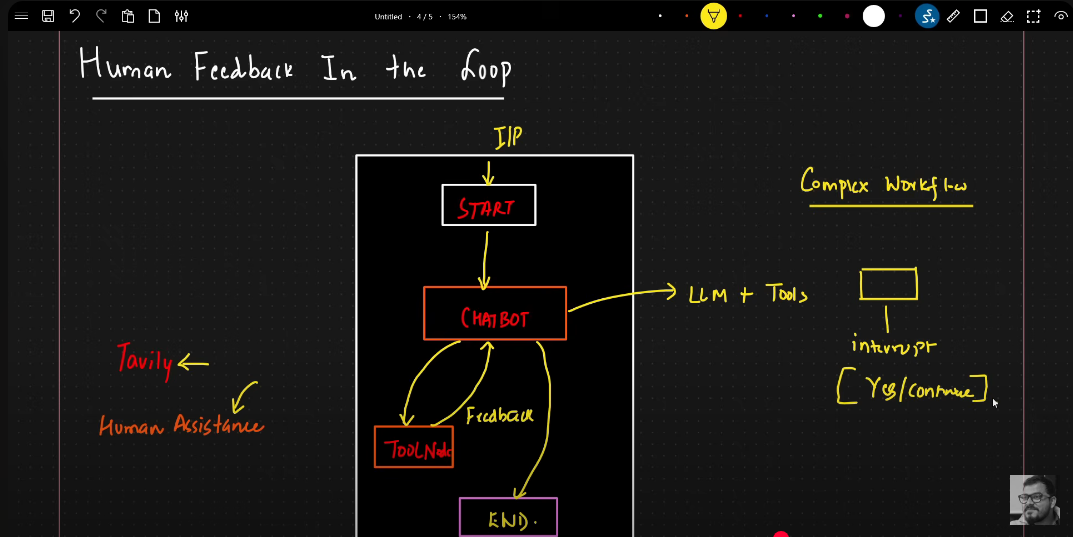

In [6]:
import os
from langchain.chat_models import init_chat_model
llm = init_chat_model("groq:llama3-8b-8192")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002696D59BD10>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002696E683F50>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

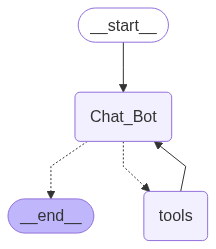

In [15]:
from typing import Annotated
from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from typing_extensions import TypedDict
from IPython.display import Image,display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode,tools_condition

from langgraph.types import Command, interrupt      # these lib is used from Human it the loop, this will interrupt and command the workflow.

class State(TypedDict):
    messages : Annotated[list,add_messages]
    

graph_builder = StateGraph(State)

@tool     #this object of the lib is imported abovw, it helps to bind the fuction with the tool which will be used by the llm in its process.
def human_assistance(query: str) -> str:
    """Requests assistance from a human ."""
    human_response = interrupt({"query" : query})
    return human_response

tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state : State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be intereupting during tool execution,
    # we disable parallel tool calling to avoid repeting any
    # tool invocations when we resume.
    
    return {"messages":[message]}

# Creating Nodes For The Graph
graph_builder.add_node("Chat_Bot", chatbot)  # Chatbot node

tool_node = ToolNode(tools=tools) # Creating a tool node(Which is always a class object)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "Chat_Bot",
    tools_condition,
)

# Creating Edges To Connect The Nodes For The Graph
graph_builder.add_edge(START, "Chat_Bot")
graph_builder.add_edge("tools", "Chat_Bot") # If you comment tis line it wont impliment ReAct Achitercture.
graph_builder.add_edge("Chat_Bot", END)

memory = MemorySaver()  # Provides Memory To The llm To Store Message Memory And Help To Build Context.
graph=graph_builder.compile(checkpointer=memory)


# Display's Graph
display(Image(graph.get_graph().draw_mermaid_png())) 

In [20]:
user_input = "I need some expert guidance and assistance for building an AI agent. Could you request assistance for me from a expert?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": user_input},
    config,
    stream_mode="values",
)

for event in events:
    if "messages" in event:
        event ["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance and assistance for building an AI agent. Could you request assistance for me from a expert?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (ptmdpjnve)
 Call ID: ptmdpjnve
  Args:
    query: Expert guidance and assistance for building an AI agent


In [21]:
human_response = (
"We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
 "It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph. stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages" ] [-1].pretty_print ()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (ptmdpjnve)
 Call ID: ptmdpjnve
  Args:
    query: Expert guidance and assistance for building an AI agent
================================= Tool Message =================================
Name: human_assistance

{"data": "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent.It's much more reliable and extensible than simple autonomous agents."}
================================== Ai Message ==================================

I already received a similar response earlier. It seems that LangGraph was recommended as a suitable solution for building an AI agent. I would like to explore this further and ask a follow-up question:

"Can you please provide more information about LangGraph, such as its features, capabilities, and any specific use cases where it has been successfully applied? Additionally, what are the benefits of using LangGraph

## Bulding MCP Servers

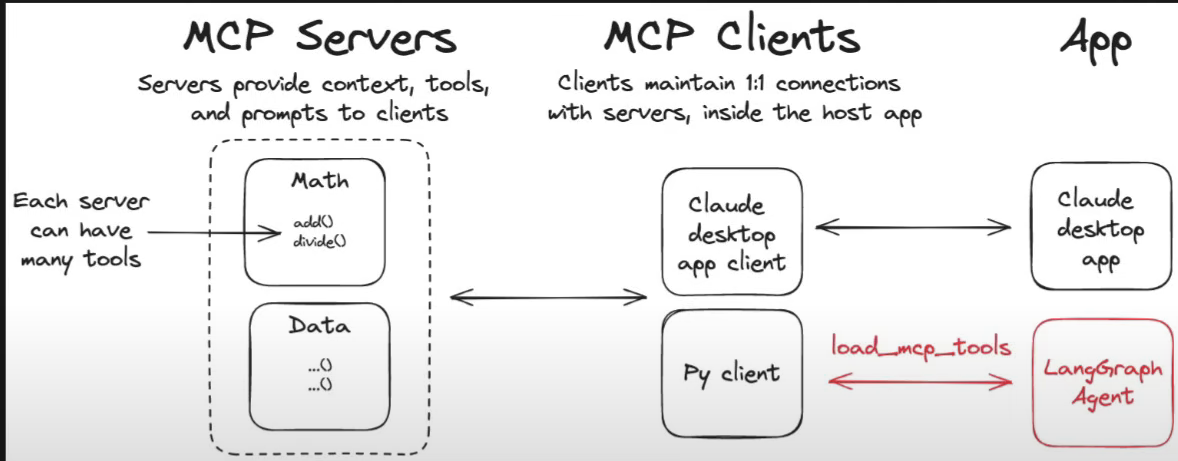